# LightGBM PHISHING classifier for the 23-10 demo

Once the loader has loaded the data and applied the transformations, we can load the resulting parquets and prepare for model training. We then split the data into training and test sets and train a model.

In [16]:
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
from pyarrow import Table
from transformers.cast_timestamp import cast_timestamp

def union_tables(tables: [pa.Table]) -> pa.Table:
    union_table = tables[0]
    for table in tables[1:]:
        right_not_in_union = union_table.join(right_table=table, keys='domain_name', join_type='right anti',
                                              coalesce_keys=True, use_threads=True)
        union_table = pa.concat_tables([union_table, right_not_in_union])
    return union_table

##################################
# EDIT to specify the model name #
##################################
model_name = "demo_phishing"     
##################################

# #############################################################
# EDIT this to specify benign / malicious datasets to use     #
# #############################################################
benign_dataset_filenames = [
    'floor/benign_2310.parquet',
    'floor/cesnet2.parquet'
]
malicious_dataset_filenames = [
    'floor/phishing_2310.parquet',
]
# #############################################################
# EDIT this for to set appropriate labels (malware, dga, ...) #
# #############################################################
benign_label = "benign"
malicious_label = "phishing"
# #############################################################

# Unify malicious datasets and benign datasets
schema = (pq.read_table(malicious_dataset_filenames[0])).schema # Use the schema from the first malicious filename
benign_tables = [pq.read_table(filename).cast(schema) for filename in benign_dataset_filenames]
malicious_tables = [pq.read_table(filename).cast(schema) for filename in malicious_dataset_filenames]
malicious = union_tables(malicious_tables)
benign = union_tables(benign_tables)

# Convert pyarrow tables to pandas dataframes
df_benign = benign.to_pandas()
df_malicious = malicious.to_pandas()

# Set appropriate labels
df_benign["label"] = benign_label
df_malicious["label"] = malicious_label
class_map = {benign_label: 0, malicious_label: 1}

# Concatentate benign and malicious
df = pd.concat([df_benign, df_malicious])

# Drop domain name column
df.drop("domain_name", axis=1, inplace=True)

# Cast timestamps            
df = cast_timestamp(df)

# Handle NaNs
df.fillna(-1, inplace=True)

labels = df['label'].apply(lambda x: class_map[x]) # y vector
features = df.drop('label', axis=1).copy() # X matrix

print(f"Total records: {len(df)}")

# Print preview
df


Total records: 1461192


,label,dns_has_dnskey,dns_A_count,dns_AAAA_count,dns_MX_count,dns_NS_count,dns_TXT_count,dns_SOA_count,dns_CNAME_count,dns_zone_level,...,rdap_ip_v4_count,rdap_ip_v6_count,rdap_ip_shortest_v4_prefix_len,rdap_ip_longest_v4_prefix_len,rdap_ip_shortest_v6_prefix_len,rdap_ip_longest_v6_prefix_len,rdap_ip_avg_admin_name_len,rdap_ip_avg_admin_name_entropy,rdap_ip_avg_admin_email_len,rdap_ip_avg_admin_email_entropy
0,benign,0.0,1,1,1,4,12,1,0,0,...,21,18,15.0,19.0,32.0,37.0,7.435897,0.217272,17.102564,0.117073
1,benign,0.0,1,1,1,4,3,1,0,0,...,21,18,15.0,19.0,32.0,37.0,7.435897,0.217272,17.102564,0.117073
2,benign,0.0,2,0,6,5,3,1,0,0,...,28,4,10.0,27.0,18.0,24.0,18.062500,0.211240,23.718750,0.162255
3,benign,0.0,5,0,1,2,9,1,0,0,...,55,0,10.0,20.0,0.0,0.0,15.163636,0.251491,23.163636,0.159750
4,benign,0.0,1,1,1,4,5,1,0,0,...,13,12,16.0,23.0,29.0,40.0,3.600000,0.119589,6.840000,0.066526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64309,phishing,0.0,1,0,0,0,0,0,0,0,...,1,0,24.0,24.0,0.0,0.0,16.000000,0.226562,16.000000,0.234375
64310,phishing,1.0,0,0,0,0,0,0,0,0,...,0,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
64311,phishing,0.0,2,0,0,0,0,0,0,0,...,2,0,24.0,24.0,0.0,0.0,24.000000,0.155007,12.000000,0.257080
64312,phishing,0.0,0,0,0,0,0,0,1,0,...,2,2,12.0,13.0,32.0,32.0,5.000000,0.464386,18.000000,0.198468


# Train-Test split

In [12]:
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, module="sklearn")

X_train, X_test, y_train, y_test = train_test_split(
  features,
  labels,
  test_size=0.2,
  random_state=42,
  shuffle=True, 
  stratify=labels
)

# LightGBM

[LightGBM] [Info] Number of positive: 51451, number of negative: 792927
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12367
[LightGBM] [Info] Number of data points in the train set: 844378, number of used features: 142
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.060934 -> initscore=-2.735101
[LightGBM] [Info] Start training from score -2.735101
Accuracy: 1.00
Precision: 0.98
Recall: 0.97
F1 Score: 0.98
              precision    recall  f1-score   support

           0     0.9978    0.9990    0.9984    198232
           1     0.9846    0.9666    0.9755     12863

    accuracy                         0.9970    211095
   macro avg     0.9912    0.9828    0.9870    211095
weighted avg     0.9970    0.9970    0.9970    211095



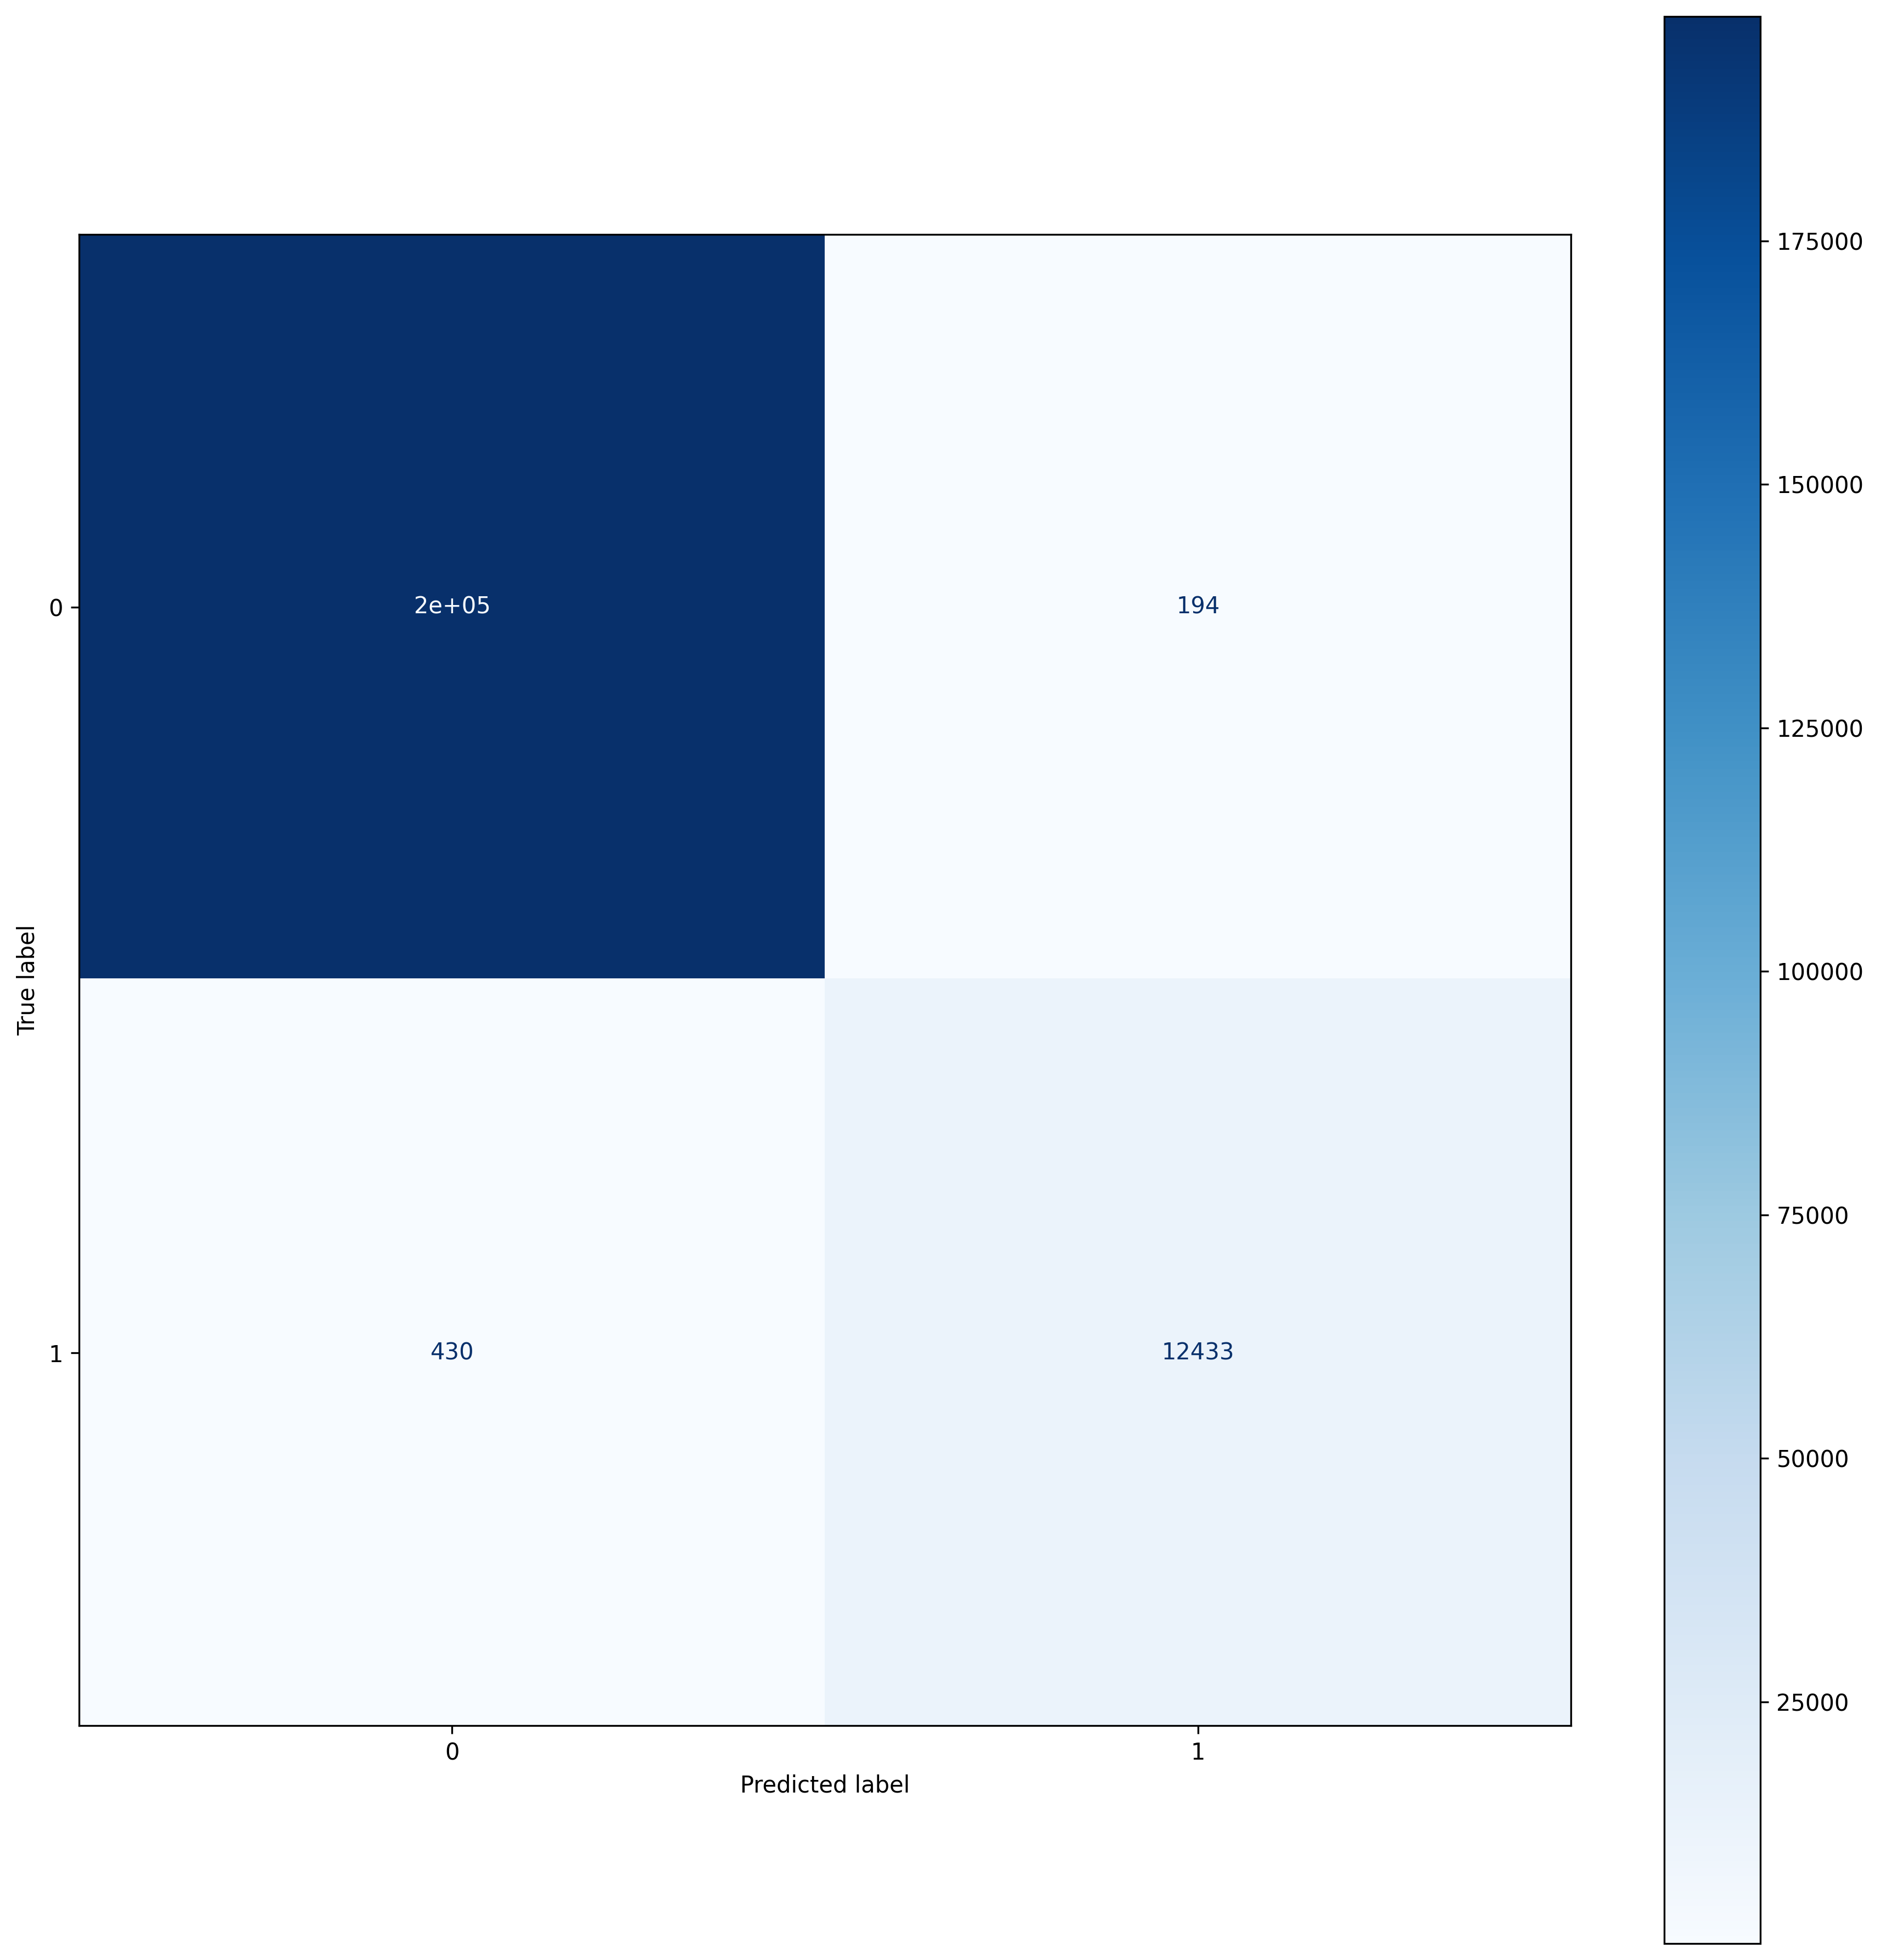

TN: 198038 <-- True Negatives
FP: 194 <-- False Positives
FN: 430 <-- False Negatives
TP: 12433 <-- True Positives
FPR:0.0009786512772912547 <-- False Positive Rate
TPR:0.9665707844204307 <-- True Positive Rate (same as Recall)


In [13]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# LightGBM parameters
params = {
    'objective': 'binary',  # binary classification
    'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
    'n_estimators': 3030,  # Number of boosted trees to fit, equivalent to number of boosting iterations
    'num_leaves': 89,
    'max_depth': 16,
    'random_state': 7,
    'learning_rate': 0.1,
    'min_child_samples': 18,
    'scale_pos_weight': 1.6,
    'colsample_bytree': 0.9,
    'reg_lambda': 0.1,
}

model = lgb.LGBMClassifier(**params)

# set to True to cross validate
do_cross_val = False
if do_cross_val:
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
    results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1')
    print("F1: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

# at last, train the model
_ = model.fit(X_train, y_train)

#
import pickle
pickle.dump(model, open("lgbm_" + model_name + ".pkl", "wb"))

# Evaluate the model on the test set
y_pred = model.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
print(f'Precision: {precision_score(y_test, y_pred, zero_division=1):.2f}')
print(f'Recall: {recall_score(y_test, y_pred):.2f}')
print(f'F1 Score: {f1_score(y_test, y_pred):.2f}')


from sklearn.metrics import classification_report, ConfusionMatrixDisplay, det_curve
print(classification_report(y_test, y_pred, digits=4))

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)  # Compute confusion matrix

#conf_matrix = confusion_matrix(y_test, predicted)
tn, fp, fn, tp = cm.ravel()

# Calculate False Positive Rate (FPR)
fpr = fp / (fp + tn)
tpr = tp / (tp + fn)

print("TN: " + str(tn) + " <-- True Negatives")
print("FP: " + str(fp) + " <-- False Positives")
print("FN: " + str(fn) + " <-- False Negatives")
print("TP: " + str(tp) + " <-- True Positives")

print("FPR:" + str(fpr) + " <-- False Positive Rate")
print("TPR:" + str(tpr) + " <-- True Positive Rate (same as Recall)")

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)  # Create display object
disp.plot(cmap=plt.cm.Blues)  # Plot confusion matrix
plt.show()  # Show the plot





Fitting 2 folds for each of 3 candidates, totalling 6 fits
[LightGBM] [Info] Number of positive: 22510, number of negative: 488907
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13195
[LightGBM] [Info] Number of data points in the train set: 511417, number of used features: 142
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.044015 -> initscore=-3.078213
[LightGBM] [Info] Start training from score -3.078213
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

/tmp/ipykernel_1871116/3916782502.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  value = means_df[col_name][max_ids[i]]
/tmp/ipykernel_1871116/3916782502.py:85: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  id = max_ids[i]
/tmp/ipykernel_1871116/3916782502.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color = 'r' if max_ids[i] == max_ids['mean_test_score'] else 'grey'


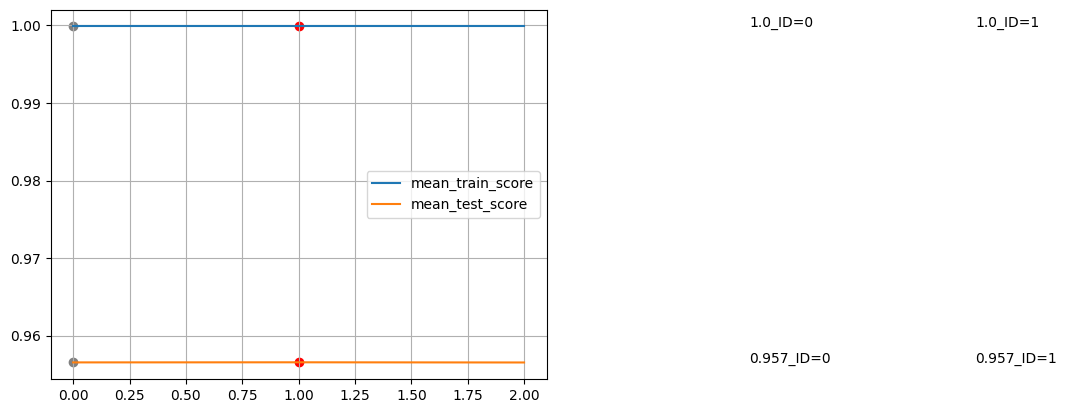

In [6]:

# Hyperparameter tuning
run_grid_search = True  # <--------------- TADY JE POTREBA TO ZAPNOUT (pokud chces tunit)
if run_grid_search:
    import pandas as pd
    from sklearn.model_selection import train_test_split
    labels = df['label'].apply(lambda x: class_map[x])
    features = df.drop('label', axis=1).copy()
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42, shuffle=True, stratify=labels)

    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import StratifiedKFold
    from lightgbm import LGBMClassifier  # Updated import

    params = {
        'objective': 'binary',  # binary classification
        'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
        #'n_estimators': 50,  # Number of boosted trees to fit, equivalent to number of boosting iterations
        'random_state': 7,
        #"n_estimators": 897,
        #"num_leaves": 59,
        'max_depth': 17,
        'learning_rate': 0.1,
        #"min_child_samples": "27",
        #"min_split_gain": 0.0,
        #'colsample_bytree': 1.0,
        "reg_lambda": 0.1,
        "min_child_samples": 18
       
    }

    clf = LGBMClassifier(**params)  # Updated classifier instantiation

    # this is your grid of parameters to search through, every combination will be tried
    grid = {
        "n_estimators": [3020, 3030, 3050],
        "num_leaves": [89],
        "max_depth": [16],
        
        #"learning_rate": [0.11, 0.12, 0.13, 0.2],
        #"subsample": [0.1],
        #reg_lambda": [0.1],
        #'min_split_gain' : [0.0, 0.1, 0.2]
        #'subsample_for_bin': [215000, 220000, 230000, 240000],
    }

    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=7)
    grid_search = GridSearchCV(
        estimator=clf,
        param_grid=grid,
        #n_jobs=-1,
        cv=cv,
        #scoring='neg_log_loss',#'f1',
        scoring='f1',#'f1',
        verbose=3,
        return_train_score=True
    )

    grid_search.fit(X_train, y_train)

    clf = grid_search.best_estimator_

    scores = pd.DataFrame(grid_search.cv_results_)
    col_names = ['mean_train_score', 'mean_test_score']

    scores = pd.DataFrame(grid_search.cv_results_)

    from numpy import array
    from numpy.ma import masked_array

    col_names = ['mean_train_score', 'mean_test_score']
    means_df = scores[col_names]
    ax = means_df.plot(kind='line', grid=True)

    from matplotlib import pyplot as plt
    plt.rcParams["figure.figsize"] = [12, 12]
    plt.rcParams["figure.autolayout"] = True

    plt.rcParams["figure.dpi"] = 300

    max_ids = means_df.idxmax(axis=0)

    for i in range(len(max_ids)):
        for col_name in col_names:
            value = means_df[col_name][max_ids[i]]
            id = max_ids[i]

            color = 'r' if max_ids[i] == max_ids['mean_test_score'] else 'grey'

            ax.scatter([id], [value],
                      marker='o',
                      color=color,
                      label='point',)

            ax.annotate(str(round(value, 3))+"_ID="+str(id),
                        (id, value),
                        xytext=(id+3, value))

    print(scores)


In [17]:
scores

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,param_num_leaves,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,2533.708642,2456.656157,35.312716,0.185451,16,2950,89,"{'max_depth': 16, 'n_estimators': 2950, 'num_l...",0.956247,0.957036,0.956641,0.000394,5,0.999867,0.999911,0.999889,0.000022
1,1639.012990,1047.851477,27.301143,0.277760,16,2950,90,"{'max_depth': 16, 'n_estimators': 2950, 'num_l...",0.955957,0.956824,0.956390,0.000434,14,0.999867,0.999911,0.999889,0.000022
2,4204.611565,3080.331982,34.967370,5.721724,16,2950,91,"{'max_depth': 16, 'n_estimators': 2950, 'num_l...",0.955161,0.957107,0.956134,0.000973,30,0.999867,0.999911,0.999889,0.000022
3,826.710254,172.991618,24.345897,0.277169,16,2980,89,"{'max_depth': 16, 'n_estimators': 2980, 'num_l...",0.956206,0.957079,0.956643,0.000437,3,0.999867,0.999911,0.999889,0.000022
4,803.041573,178.866989,28.638290,0.471289,16,2980,90,"{'max_depth': 16, 'n_estimators': 2980, 'num_l...",0.956028,0.956757,0.956392,0.000365,13,0.999867,0.999911,0.999889,0.000022
5,810.409742,188.782515,28.713663,0.110283,16,2980,91,"{'max_depth': 16, 'n_estimators': 2980, 'num_l...",0.955094,0.957040,0.956067,0.000973,43,0.999867,0.999911,0.999889,0.000022
6,556.606536,424.264936,30.838888,6.276608,16,3000,89,"{'max_depth': 16, 'n_estimators': 3000, 'num_l...",0.956186,0.957056,0.956621,0.000435,6,0.999867,0.999911,0.999889,0.000022
7,120.389196,1.881544,41.955764,0.906616,16,3000,90,"{'max_depth': 16, 'n_estimators': 3000, 'num_l...",0.955957,0.956805,0.956381,0.000424,15,0.999867,0.999911,0.999889,0.000022
8,121.758628,0.261616,42.610493,0.511372,16,3000,91,"{'max_depth': 16, 'n_estimators': 3000, 'num_l...",0.955116,0.957085,0.956101,0.000985,39,0.999867,0.999911,0.999889,0.000022
9,121.337279,1.662520,34.387704,0.874668,16,3030,89,"{'max_depth': 16, 'n_estimators': 3030, 'num_l...",0.956231,0.957099,0.956665,0.000434,1,0.999867,0.999911,0.999889,0.000022


0.963587945263269
              precision    recall  f1-score   support

           0     0.9976    0.9991    0.9984    419064
           1     0.9807    0.9471    0.9636     19294

    accuracy                         0.9968    438358
   macro avg     0.9891    0.9731    0.9810    438358
weighted avg     0.9968    0.9968    0.9968    438358

0.963587945263269
TN: 418704 <-- True Negatives
FP: 360 <-- False Positives
FN: 1021 <-- False Negatives
TP: 18273 <-- True Positives
FPR:0.0008590573277590058 <-- False Positive Rate
TPR:0.9470819944024049 <-- True Positive Rate (same as Recall)


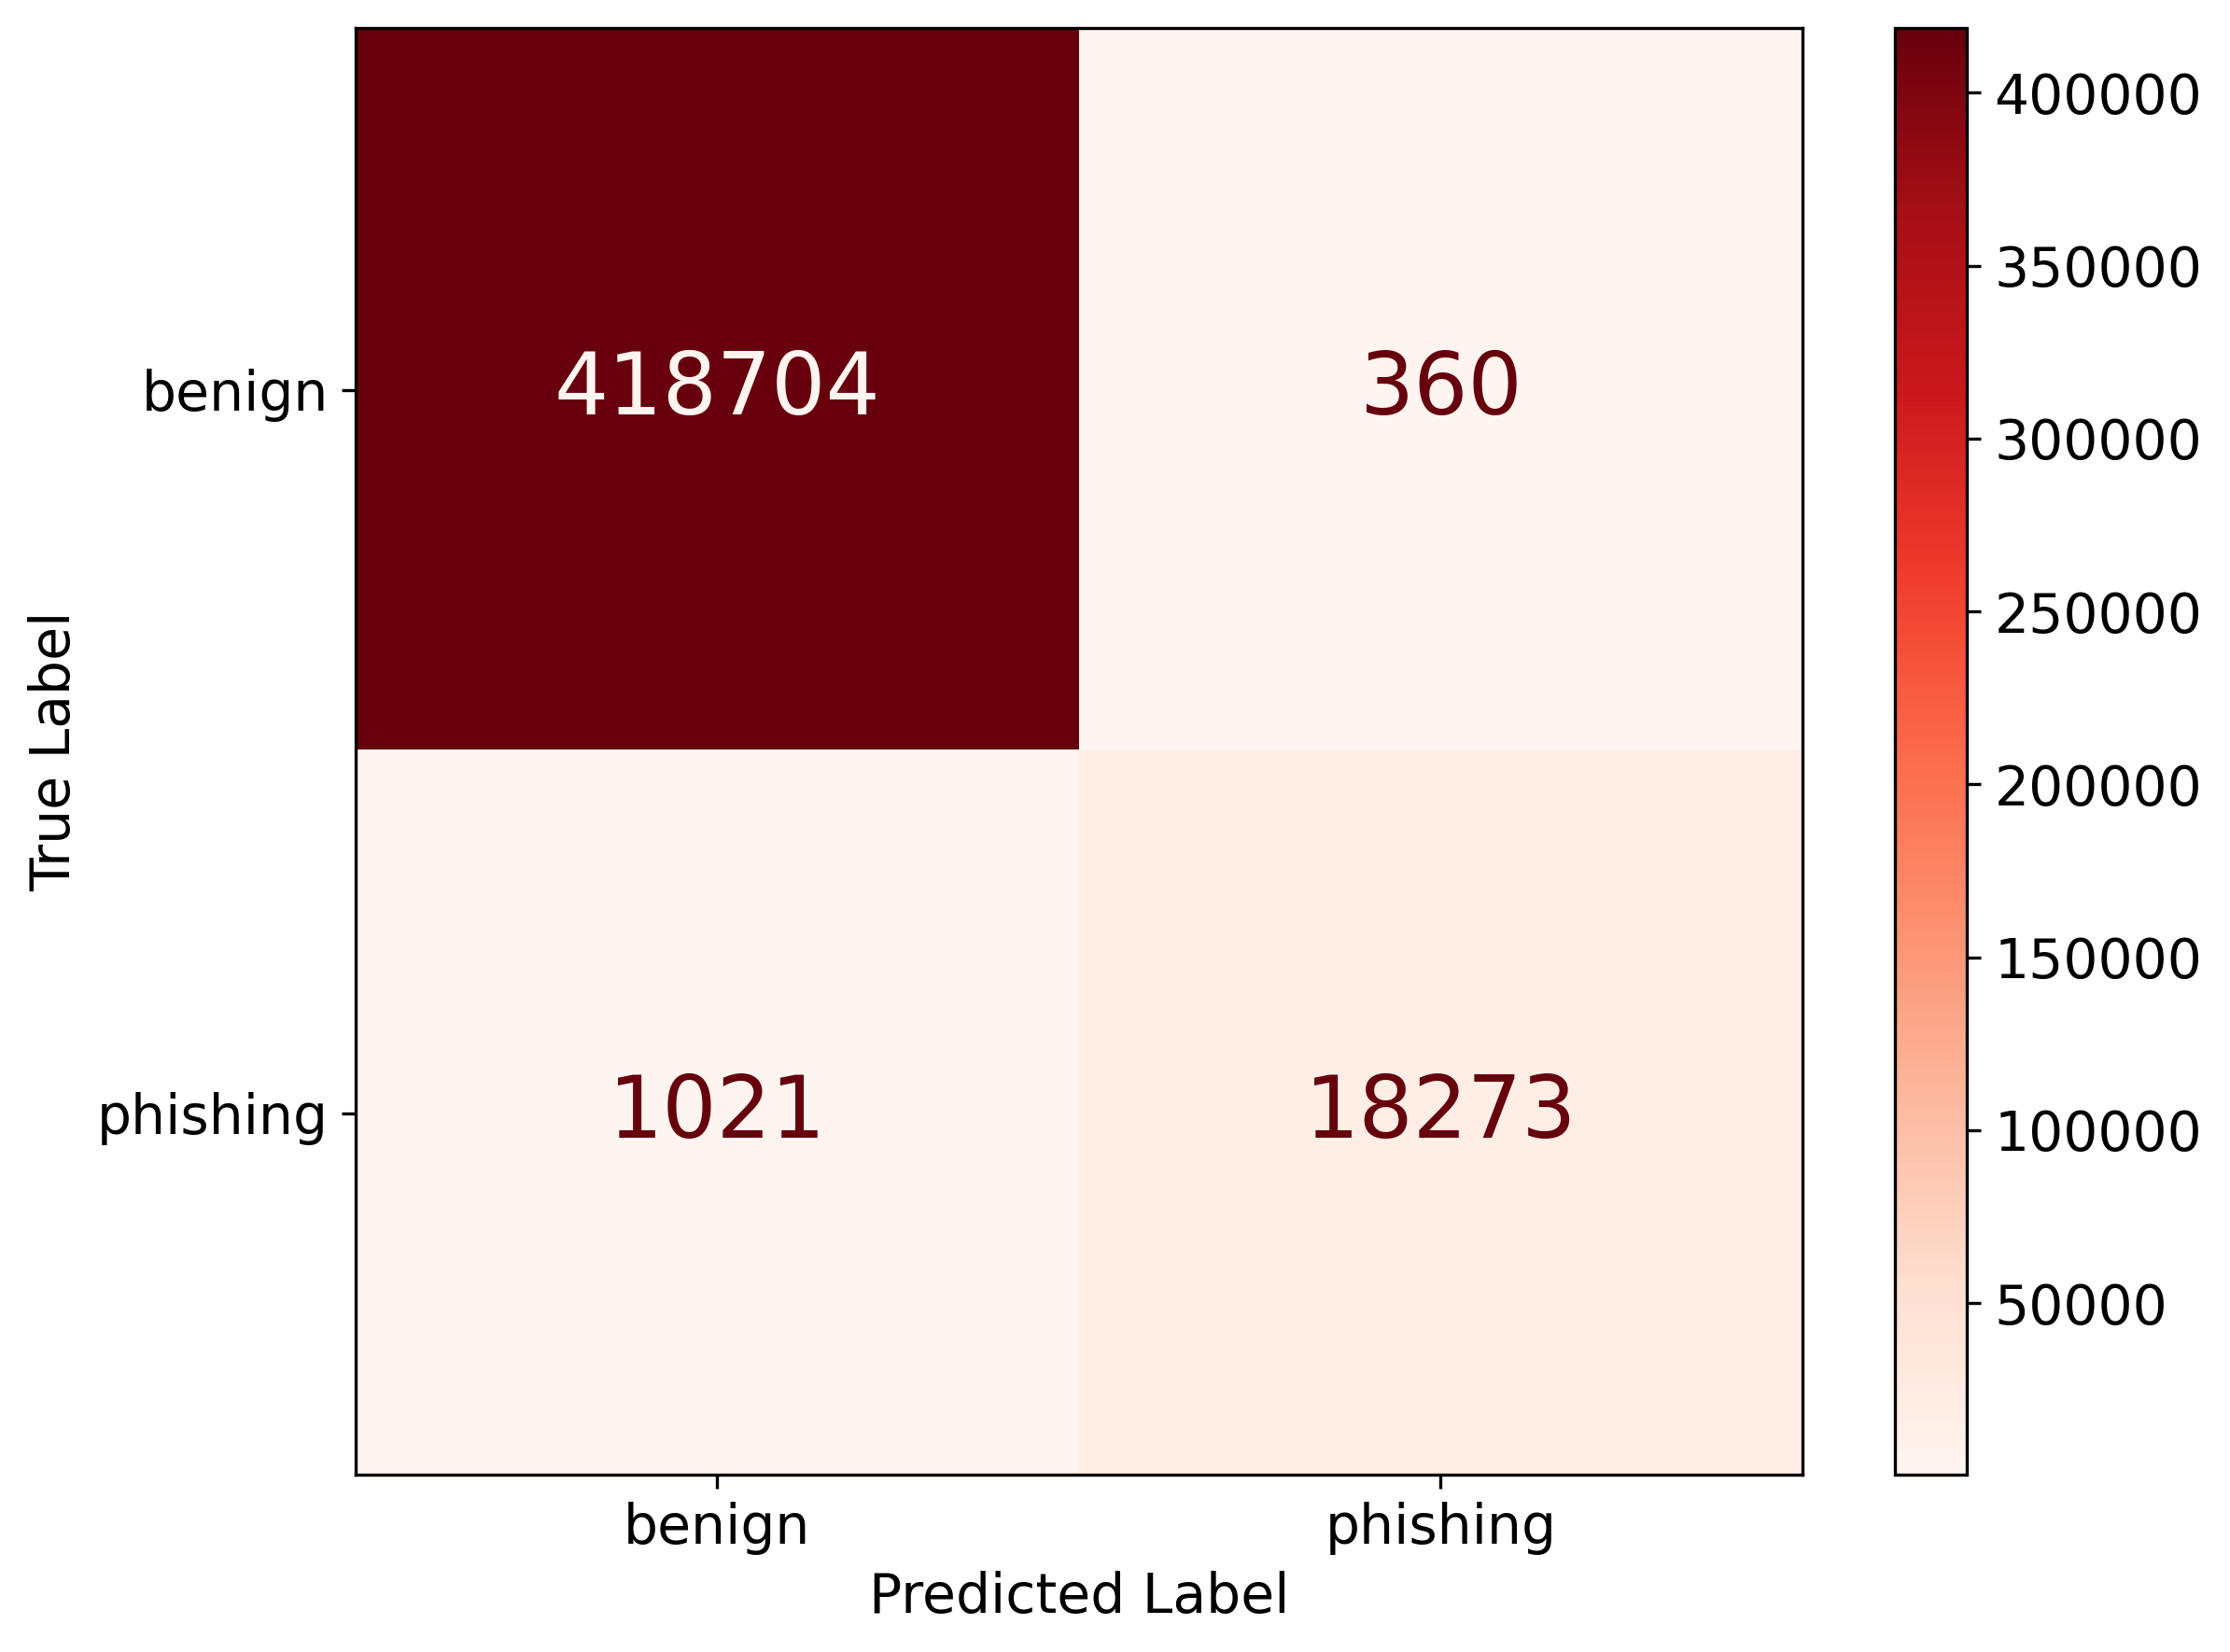

In [9]:

import pickle
model = pickle.load(open("lgbm_" + model_name + ".pkl", "rb"))

predicted = model.predict(X_test)

from sklearn.metrics import f1_score, confusion_matrix
print(f1_score(y_test, predicted))

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [8, 6]
plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.dpi"] = 300
    
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, det_curve
print(classification_report(y_test, predicted, digits=4))

f1 = f1_score(y_test, predicted)
print(f1)

conf_matrix = confusion_matrix(y_test, predicted)
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate False Positive Rate (FPR)
fpr = fp / (fp + tn)
tpr = tp / (tp + fn)

print("TN: " + str(tn) + " <-- True Negatives")
print("FP: " + str(fp) + " <-- False Positives")
print("FN: " + str(fn) + " <-- False Negatives")
print("TP: " + str(tp) + " <-- True Positives")

print("FPR:" + str(fpr) + " <-- False Positive Rate")
print("TPR:" + str(tpr) + " <-- True Positive Rate (same as Recall)")



cmd = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, text_kw={'fontsize': 22},
                                      display_labels=['benign', 'phishing'], values_format='d',
                                     cmap=plt.cm.Reds) 

# Adjust the label font sizes
cmd.ax_.tick_params(axis='x', labelsize=14)  # Adjust x-axis label font size
cmd.ax_.tick_params(axis='y', labelsize=14)  # Adjust y-axis label font size
cmd.ax_.set_xlabel('Predicted Label', fontsize=14)
cmd.ax_.set_ylabel('True Label', fontsize=14)


# Adjust colorbar (legend) font size
cbar = cmd.figure_.axes[-1]  # the colorbar should be the last axis object in the list of axes
cbar.tick_params(labelsize=14) 

plt.savefig("cfm_lgbm_" + model_name + ".pdf")

# plot_color_gradients('Sequential',
#                     ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
#                      'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
#                      'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn'])

In [10]:
class_names=class_map.values()

# initialize shap
import shap
# get shap values (use a smaller sample of the test set if you want to save coffee)
explainer = shap.TreeExplainer(model)
X_sample = X_test
shap_values = explainer.shap_values(X_sample)
# save the values for later use
import pickle
pickle.dump(shap_values, open("shap_values_lgbm_" + model_name + ".pkl", "wb"))


# load the values to start from here
import pickle
shap_values = pickle.load(open("shap_values_lgbm_" + model_name + ".pkl", "rb"))

import shap
shap.initjs()
reverse_class_map = {v: k for k, v in class_map.items()}

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [11]:
# 1. Extract SHAP values for the positive class
positive_class_shap_values = shap_values[1]

# 2. Adjust the plot_shap function
import ipywidgets as widgets
from ipywidgets import interact
plot_type = widgets.RadioButtons(
    options=['dot', 'layered_violin', 'bar'],
    value='layered_violin',
    description='Plot Type:',
    disabled=False
)
max_display = widgets.IntSlider(
    value=10,
    description='Max Display:',
    disabled=False,
    min=1,
    max=len(X_sample.columns)-1
)

@interact
def plot_shap(plot_type=plot_type, max_display=max_display):
    shap.summary_plot(positive_class_shap_values, X_sample, show=False, plot_type=plot_type, class_names=list(class_map.values()), max_display=max_display, plot_size=[10, max_display])
    plt.savefig("shap_summary_icc.pdf")


interactive(children=(RadioButtons(description='Plot Type:', index=1, options=('dot', 'layered_violin', 'bar')…

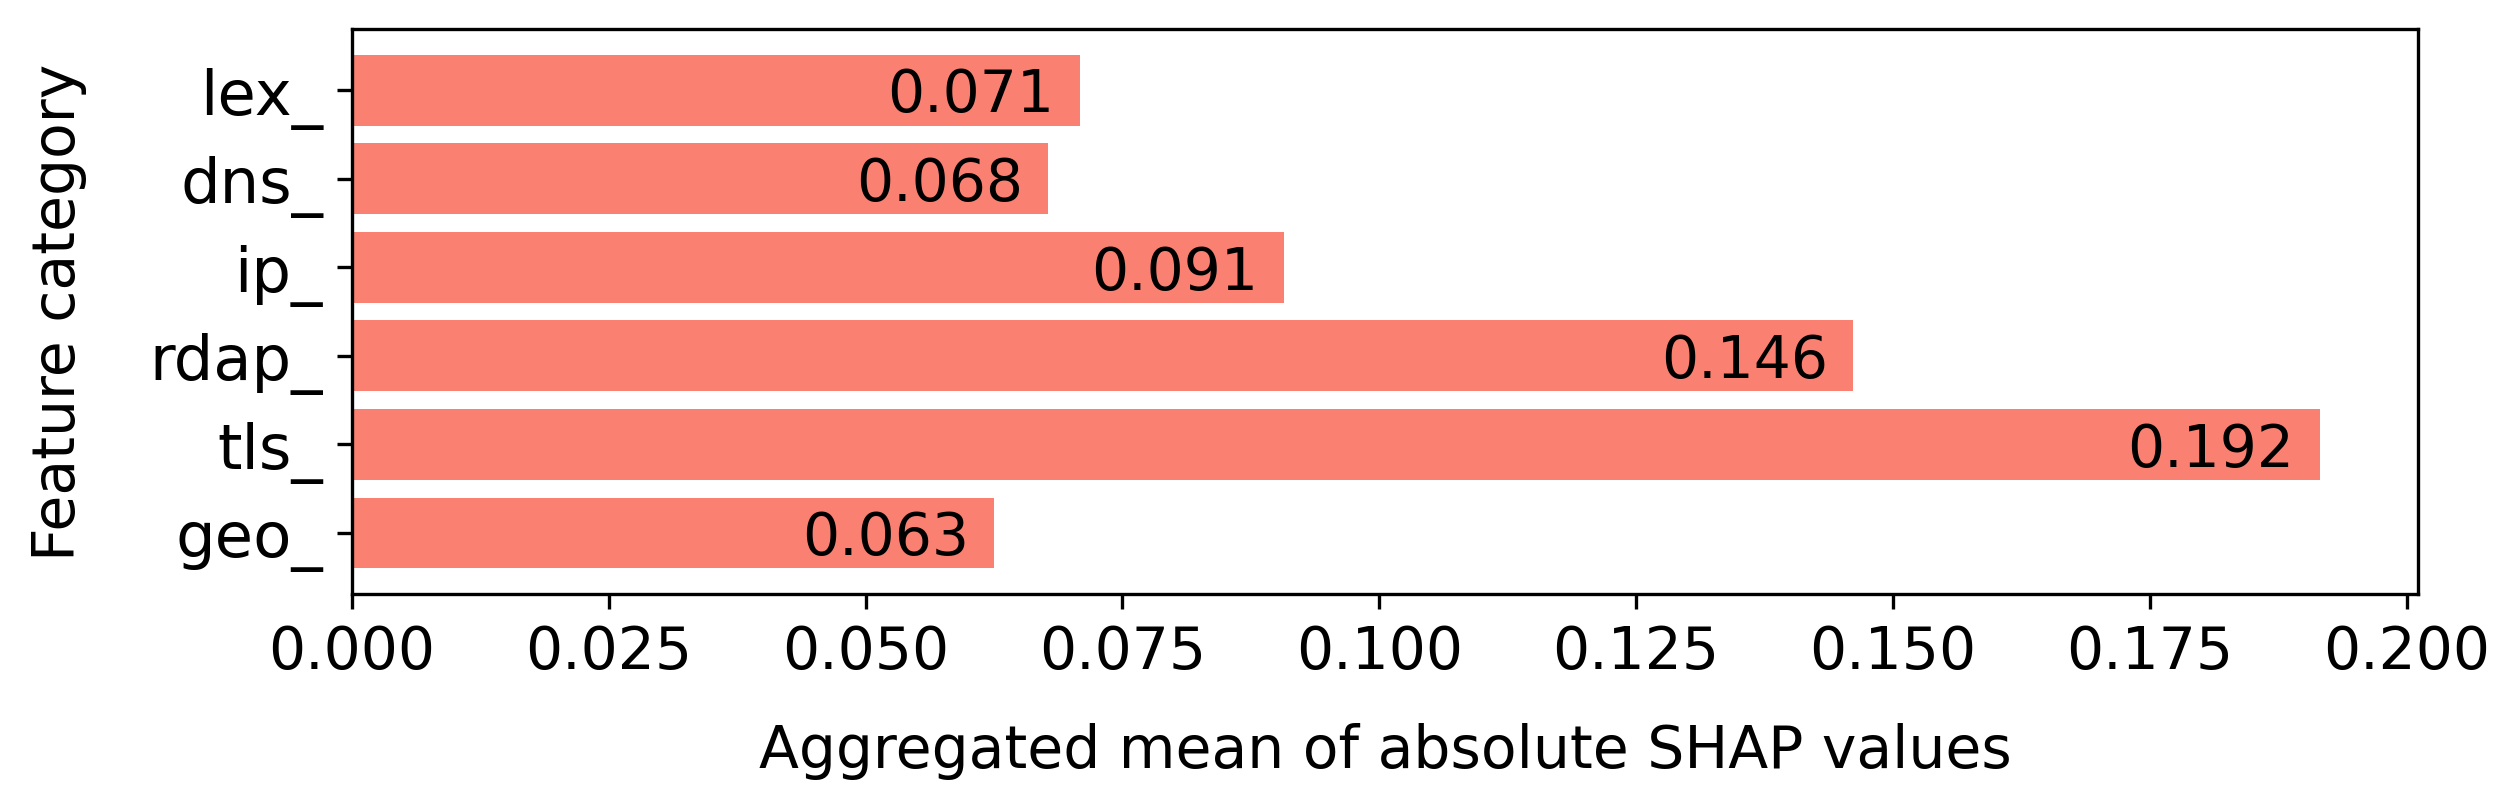

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for customization
bar_height = 0.12  # Height of each bar
spacing = 0.15  # Vertical spacing between bars
padding = 0.05  # Vertical space before the first bar and after the last bar

shap_values = positive_class_shap_values

# Calculate mean absolute shap values for each feature
mean_shap_values = np.mean(np.abs(shap_values), axis=0)

# List of feature prefixes
prefixes = ["lex_", "dns_", "ip_", "rdap_", "tls_", "geo_"]

# Dictionary to hold the aggregated mean for each prefix
aggregated_means = {}

# Compute mean of absolute SHAP values for each prefix
for prefix in prefixes:
    indices = [i for i, col_name in enumerate(X_sample.columns) if col_name.startswith(prefix)]
    group_mean_shap = [mean_shap_values[i] for i in indices]
    aggregated_means[prefix] = np.mean(group_mean_shap)

# Sort prefixes and their values by importance
#sorted_prefixes = sorted(aggregated_means, key=aggregated_means.get, reverse=False)
sorted_prefixes = list(reversed(prefixes))

sorted_prefix_values = [aggregated_means[prefix] for prefix in sorted_prefixes]

# Create the y positions for each bar
y_positions = np.arange(len(sorted_prefixes)) * spacing + padding

plt.figure(figsize=(8.5, 2.8))

# Create horizontal bar chart with adjustable bar height and spacing
bars = plt.barh(y_positions, sorted_prefix_values, color='salmon', height=bar_height)

# Customizing the chart with increased font size
plt.xlabel('Aggregated mean of absolute SHAP values', fontsize=14, labelpad=10)
plt.ylabel('Feature category', fontsize=14, labelpad=15)
plt.yticks(y_positions, sorted_prefixes, fontsize=15)
plt.xticks(fontsize=14)

# Display values on the bars with two decimal places
for bar, y_pos in zip(bars, y_positions):
    xval = bar.get_width()
    plt.text(xval - 0.013 * max(sorted_prefix_values), y_pos - 0.008, "{:.3f}".format(xval), ha='right', va='center', fontsize=14, color='black')

plt.tight_layout()

# Save and show the chart
plt.savefig("agg_shap_gbm_" + model_name + ".pdf")
plt.show()


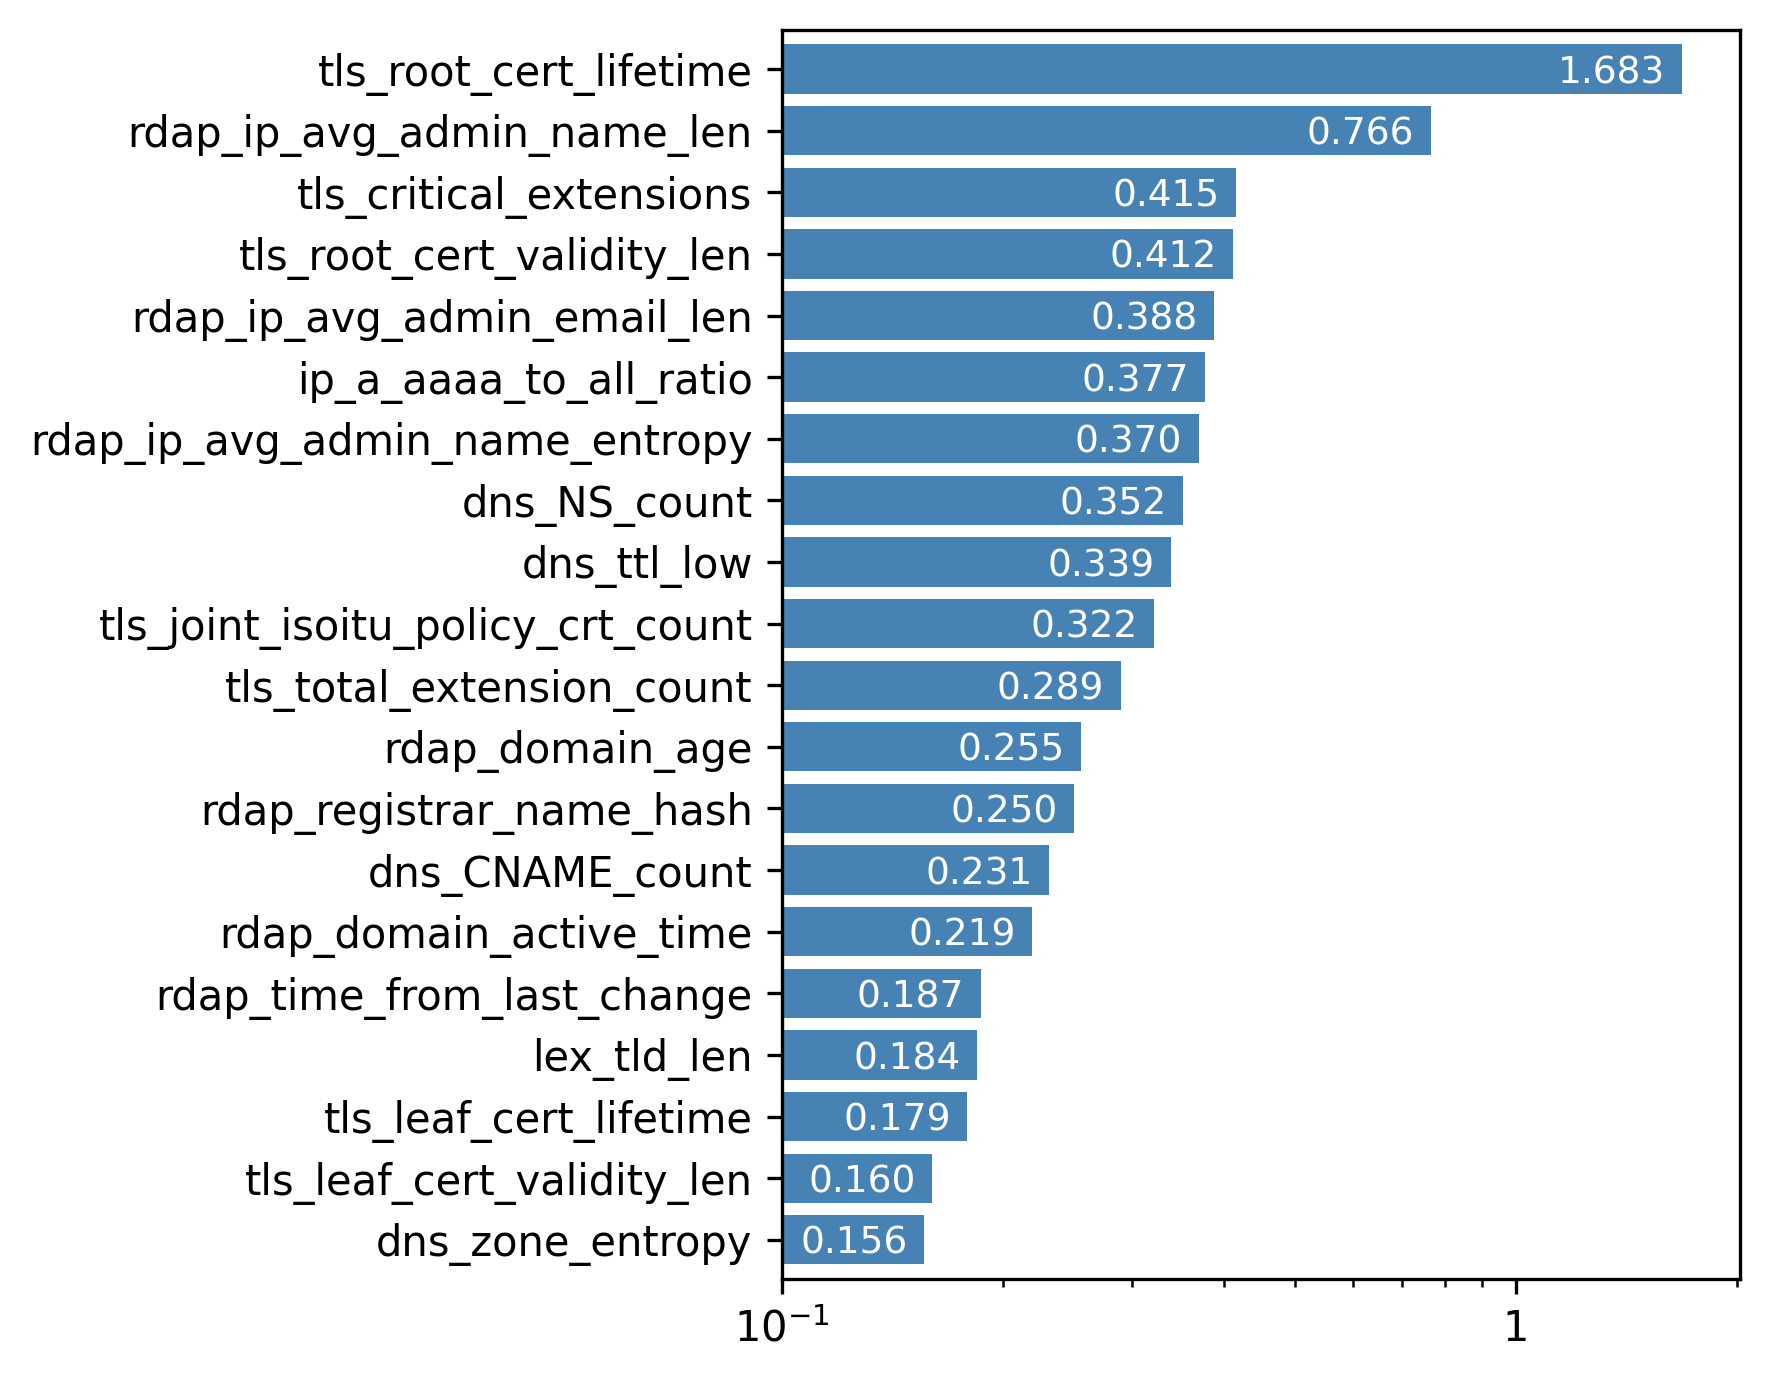

In [13]:
import numpy as np
import matplotlib.pyplot as plt

max_display=20
shap_values = positive_class_shap_values

# Calculate mean absolute shap values
mean_shap_values = np.mean(np.abs(shap_values), axis=0)

# Sort them
sorted_indices = np.argsort(mean_shap_values)

# Consider the top 'max_display' features
top_indices = sorted_indices[-max_display:]

# Custom bar height and spacing
bar_height = 0.12
spacing = 0.15
y_positions = np.arange(max_display) * spacing

colors = 'steelblue'

plt.figure(figsize=(6, 4.7))

# Plotting the bars
bars = plt.barh(y_positions, mean_shap_values[top_indices], height=bar_height, align='center', color=colors)

# Add textual values on each bar
for bar in bars:
    xval = bar.get_width()
    label_text = f'{xval:.3f}'
    
    plt.text(xval - (0.05 * xval), bar.get_y() + bar.get_height()/2 - 0.01, label_text, 
             ha='right', va='center', color='white', fontsize=9)

plt.yticks(y_positions, X_sample.columns[top_indices])
plt.ylim(y_positions[0] - 0.095, y_positions[-1] + 0.095)
plt.xscale('log')
locs, labels = plt.xticks()
new_labels = [str(int(loc)) if loc == 1 or loc == 0.1 else label.get_text() for loc, label in zip(locs, labels)]
plt.xticks(locs, new_labels)
max_shap_value = np.max(mean_shap_values[top_indices])
plt.xlim(0.1, max_shap_value*1.2)

plt.tight_layout()
plt.savefig("shap_summary_bar_gbm_" + model_name + ".pdf")
plt.show()


In [16]:

fv = {'dns_has_dnskey': {0: 0}, 'dns_A_count': {0: 2}, 'dns_AAAA_count': {0: 2}, 'dns_txt_avg_len': {0:0}, 'dns_MX_count': {0: 0}, 'dns_NS_count': {0: 0}, 'dns_TXT_count': {0: 0}, 'dns_SOA_count': {0: 0}, 'dns_CNAME_count': {0: 0}, 'dns_zone_level': {0: 0}, 'dns_zone_digit_count': {0: 0}, 'dns_zone_len': {0: 10}, 'dns_zone_entropy': {0: 0.2921928094887362}, 'dns_resolved_record_types': {0: 2}, 'dns_dnssec_score': {0: 0.0}, 'dns_ttl_avg': {0: 85.71428571428571}, 'dns_ttl_stdev': {0: 135.52618543578768}, 'dns_ttl_low': {0: 0.7142857142857143}, 'dns_ttl_mid': {0: 0.2857142857142857}, 'dns_ttl_distinct_count': {0: 2}, 'dns_soa_primary_ns_level': {0: -1}, 'dns_soa_primary_ns_digit_count': {0: -1}, 'dns_soa_primary_ns_len': {0: -1}, 'dns_soa_primary_ns_entropy': {0: -1}, 'dns_soa_email_level': {0: -1}, 'dns_soa_email_digit_count': {0: -1}, 'dns_soa_email_len': {0: -1}, 'dns_soa_email_entropy': {0: -1}, 'dns_soa_refresh': {0: -1}, 'dns_soa_retry': {0: -1}, 'dns_soa_expire': {0: -1}, 'dns_soa_min_ttl': {0: -1}, 'dns_domain_name_in_mx': {0: False}, 'dns_mx_avg_len': {0: -1}, 'dns_mx_avg_entropy': {0: -1}, 'dns_txt_avg_entropy': {0: -1}, 'dns_txt_external_verification_score': {0: 0}, 'dns_txt_spf_exists': {0: 0}, 'dns_txt_dkim_exists': {0: 0}, 'dns_txt_dmarc_exists': {0: 0}, 'ip_count': {0: 4}, 'ip_mean_average_rtt': {0: 3.865}, 'ip_v4_ratio': {0: 0.5}, 'ip_a_aaaa_to_all_ratio': {0: 1.0}, 'ip_entropy': {0: -0.0}, 'ip_as_address_entropy': {0: -0.0}, 'ip_asn_entropy': {0: -0.0}, 'ip_distinct_as_count': {0: 1}, 'tls_has_tls': {0: True}, 'tls_chain_len': {0: 4}, 'tls_negotiated_version_id': {0: 3}, 'tls_negotiated_cipher_id': {0: 2}, 'tls_root_cert_validity_len': {0: 1349}, 'tls_root_cert_lifetime': {0: 1003}, 'tls_leaf_cert_validity_len': {0: 90}, 'tls_leaf_cert_lifetime': {0: 12}, 'tls_broken_chain': {0: 0}, 'tls_expired_chain': {0: 0}, 'tls_total_extension_count': {0: 30}, 'tls_critical_extensions': {0: 7}, 'tls_with_policies_crt_count': {0: 4}, 'tls_percentage_crt_with_policies': {0: 1.0}, 'tls_x509_anypolicy_crt_count': {0: 0}, 'tls_iso_policy_crt_count': {0: 0}, 'tls_joint_isoitu_policy_crt_count': {0: 4}, 'tls_subject_count': {0: 2}, 'tls_server_auth_crt_count': {0: 2}, 'tls_client_auth_crt_count': {0: 2}, 'tls_CA_certs_in_chain_ratio': {0: 0.5}, 'tls_unique_SLD_count': {0: 1}, 'tls_common_name_count': {0: 4}, 'lex_name_len': {0: 24}, 'lex_has_digit': {0: 0}, 'lex_phishing_keyword_count': {0: 0}, 'lex_consecutive_chars': {0: 1}, 'lex_tld_len': {0: 4}, 'lex_sld_len': {0: 5}, 'lex_sld_norm_entropy': {0: 0.3843856189774725}, 'lex_sub_count': {0: 1}, 'lex_stld_unique_char_count': {0: 7}, 'lex_begins_with_digit': {0: 0}, 'lex_www_flag': {0: 0}, 'lex_sub_max_consonant_len': {0: 4}, 'lex_sub_norm_entropy': {0: 0.18146292444281242}, 'lex_sub_digit_count': {0: 0.0}, 'lex_sub_digit_ratio': {0: 0.0}, 'lex_sub_vowel_count': {0: 5}, 'lex_sub_vowel_ratio': {0: 0.2777777777777778}, 'lex_sub_consonant_count': {0: 13}, 'lex_sub_consonant_ratio': {0: 0.7222222222222222}, 'lex_sub_non_alphanum_count': {0: 0}, 'lex_sub_non_alphanum_ratio': {0: 0.0}, 'lex_sub_hex_count': {0: 4}, 'lex_sub_hex_ratio': {0: 0.2222222222222222}, 'lex_bigram_matches': {0: 4}, 'lex_trigram_matches': {0: 0}, 'lex_avg_part_len': {0: 7.333333333333333}, 'lex_stdev_part_lens': {0: 4.0276819911981905}, 'lex_longest_part_len': {0: 13}, 'lex_shortest_sub_len': {0: 18}, 'geo_countries_count': {0: 2}, 'geo_lat_stdev': {0: 0.0}, 'geo_lon_stdev': {0: 0.0}, 'geo_continent_hash': {0: 2}, 'geo_countries_hash': {0: 9000}, 'rdap_registration_period': {0: 94694400000000000}, 'rdap_domain_age': {0: 81858014000000000}, 'rdap_time_from_last_change': {0: 4821155000000000}, 'rdap_domain_active_time': {0: 94694400000000000}, 'rdap_has_dnssec': {0: False}, 'rdap_registrar_name_len': {0: 14}, 'rdap_registrar_name_entropy': {0: 0.24134167810615548}, 'rdap_registrar_name_hash': {0: 2073010348}, 'rdap_registrant_name_len': {0: 52}, 'rdap_registrant_name_entropy': {0: 0.0765247446216602}, 'rdap_admin_name_len': {0: 0}, 'rdap_admin_name_entropy': {0: 0}, 'rdap_admin_email_len': {0: 0}, 'rdap_admin_email_entropy': {0: 0.0765247446216602}, 'rdap_ip_v4_count': {0: 2}, 'rdap_ip_v6_count': {0: 2}, 'rdap_ip_shortest_v4_prefix_len': {0: 12}, 'rdap_ip_longest_v4_prefix_len': {0: 12}, 'rdap_ip_shortest_v6_prefix_len': {0: 32}, 'rdap_ip_longest_v6_prefix_len': {0: 32}, 'rdap_ip_avg_admin_name_len': {0: 5.0}, 'rdap_ip_avg_admin_name_entropy': {0: 0.46438561897747244}, 'rdap_ip_avg_admin_email_len': {0: 18.0}, 'rdap_ip_avg_admin_email_entropy': {0: 0.19846840285122885}}
testdf = df.from_dict(fv)
testdf
testdf = testdf[X_test.columns]

class_map = ['benign', 'phishing']

predicted = model.predict(testdf)
predicted_proba = model.predict_proba(testdf)

print(class_map[predicted[0]])
print(predicted_proba[0])

X_test.head()

phishing
[0.00102003 0.99897997]


,dns_has_dnskey,dns_A_count,dns_AAAA_count,dns_MX_count,dns_NS_count,dns_TXT_count,dns_SOA_count,dns_CNAME_count,dns_zone_level,dns_zone_digit_count,...,rdap_ip_v4_count,rdap_ip_v6_count,rdap_ip_shortest_v4_prefix_len,rdap_ip_longest_v4_prefix_len,rdap_ip_shortest_v6_prefix_len,rdap_ip_longest_v6_prefix_len,rdap_ip_avg_admin_name_len,rdap_ip_avg_admin_name_entropy,rdap_ip_avg_admin_email_len,rdap_ip_avg_admin_email_entropy
1371402,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
791275,0.0,2,2,0,0,0,0,0,0,0,...,2,2,12.0,13.0,32.0,32.0,5.0,0.464386,18.0,0.198468
1360665,1.0,1,0,1,4,1,1,0,0,0,...,1,0,24.0,24.0,0.0,0.0,0.0,0.000000,0.0,0.000000
1163594,0.0,0,0,0,0,0,0,1,0,0,...,1,0,23.0,23.0,0.0,0.0,0.0,0.000000,0.0,0.000000
449556,0.0,1,0,0,3,0,1,0,0,0,...,1,0,17.0,17.0,0.0,0.0,6.0,0.430827,20.0,0.184209
